In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel('./WA_Fn-UseC_-Marketing-Campaign-Eff-UseC_-FastF (1).xlsx', sheet=1)

---

## Step 1 - Format Data

In [3]:
data.dtypes

MarketID              int64
MarketSize           object
LocationID            int64
AgeOfStore            int64
Promotion             int64
Week                  int64
SalesInThousands    float64
dtype: object

In [4]:
data.MarketSize.unique()

array([u'Medium', u'Small', u'Large'], dtype=object)

In [5]:
data['MarketSize'] = [1 if i=='Small' else 2 if i=='Medium' else 3 if i=='Large' else 0 for i in data['MarketSize']]

cats = data.columns[:-1]
for i in cats:
    data[i] = data[i].astype('category')

---

## Step 2 - Data Exploration

In [6]:
data.describe()

# There is a large variance in the Sales figures (standard deviation is 16)

,SalesInThousands
count,548.000000
mean,53.466204
std,16.755216
min,17.340000
25%,42.545000
50%,50.200000
75%,60.477500
max,99.650000


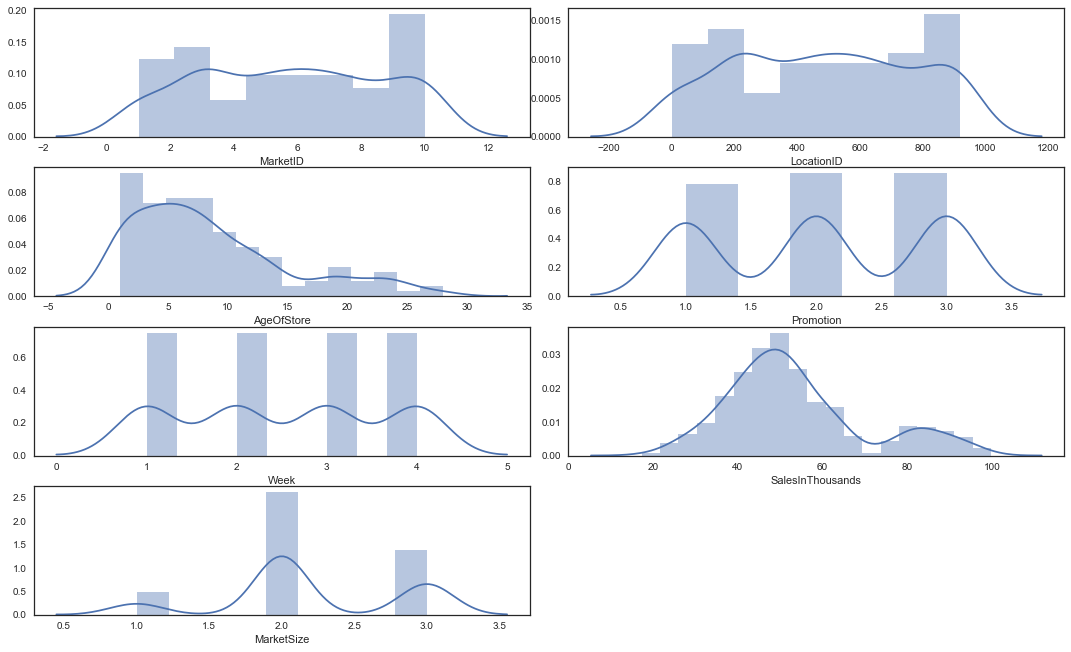

In [7]:
%matplotlib inline
sns.set_style('white')
plt.rcParams['figure.figsize'] = 15,9

f, ax = plt.subplots(4,2)
f.tight_layout()

a = sns.distplot(data['MarketID'], ax=ax[0,0])
b = sns.distplot(data['LocationID'], ax=ax[0,1])
c = sns.distplot(data['AgeOfStore'], ax=ax[1,0])
d = sns.distplot(data['Promotion'], ax=ax[1,1])
e = sns.distplot(data['Week'], ax=ax[2,0])
g = sns.distplot(data['SalesInThousands'], ax=ax[2,1])
g = sns.distplot(data['MarketSize'], ax=ax[3,0])
f.delaxes(ax.flatten()[7])

plt.show()

# Most records found in the MarketId #9
# Most of the stores are less than 10 years old
# Records are evenly distributed across Promotion and Week
# Sales has a normal distribution, with the median being roughly $50k per week
# Medium Market Size has the most records

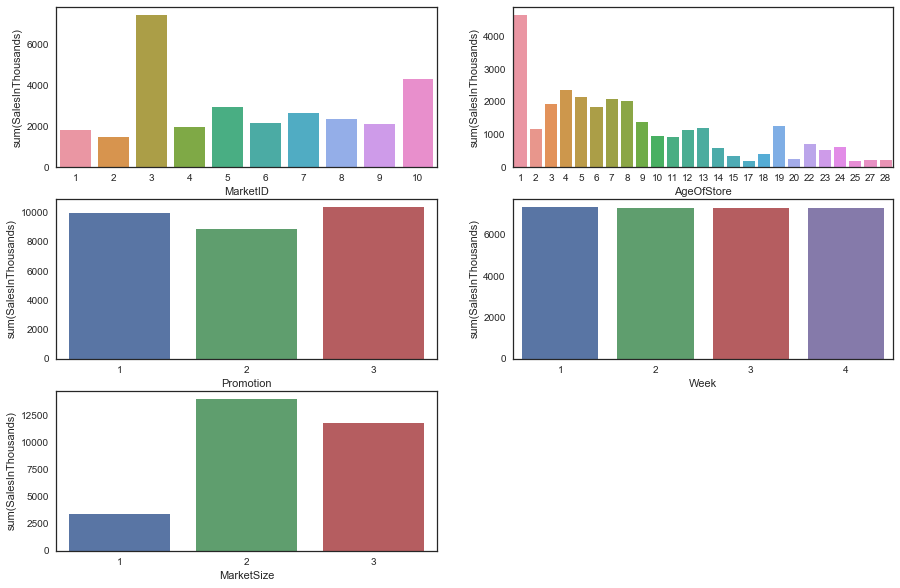

In [8]:
plt.rcParams['figure.figsize'] = 15,10

f, ax = plt.subplots(3,2)

sns.barplot(x=data['MarketID'], y=data['SalesInThousands'], estimator=sum, ci=False, ax=ax[0,0])
sns.barplot(x=data['AgeOfStore'], y=data['SalesInThousands'], estimator=sum, ci=False, ax=ax[0,1])
sns.barplot(x=data['Promotion'], y=data['SalesInThousands'], estimator=sum, ci=False, ax=ax[1,0])
sns.barplot(x=data['Week'], y=data['SalesInThousands'], estimator=sum, ci=False, ax=ax[1,1])
sns.barplot(x=data['MarketSize'], y=data['SalesInThousands'], estimator=sum, ci=False, ax=ax[2,0])
f.delaxes(ax.flatten()[5])
plt.show()

# Market #3 is leading sales
# New stores are leading in sales
# Weeks and Promotions have little effect on sales
# Medium sized markets have the most sales

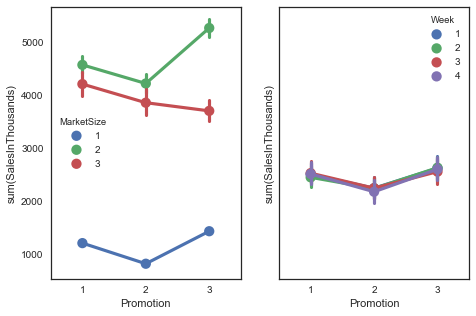

In [9]:
plt.rcParams['figure.figsize'] = 7.5,5

f, ax = plt.subplots(1,2, sharey=True)

sns.pointplot(data=data, hue='MarketSize', x='Promotion', y='SalesInThousands', ax=ax[0], estimator=sum)
sns.pointplot(data=data, hue='Week', x='Promotion', y='SalesInThousands', ax=ax[1], estimator=sum)

plt.show()

# Promotion 2 is the weakest performer when looking at aggregate sales figures across all Weeks and 
# two out of the three markets

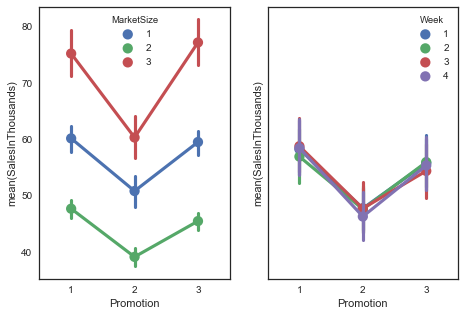

In [10]:
plt.rcParams['figure.figsize'] = 7.5,5

f, ax = plt.subplots(1,2, sharey=True)

sns.pointplot(data=data, hue='MarketSize', x='Promotion', y='SalesInThousands', ax=ax[0])
sns.pointplot(data=data, hue='Week', x='Promotion', y='SalesInThousands', ax=ax[1])

plt.show()

# Promotion 2 is the weakest performer when looking at average sales across all Market Sizes and Weeks

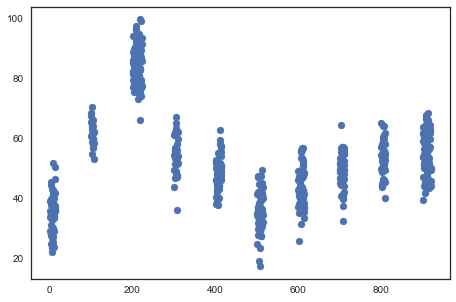

In [11]:
# quick check for outliers. everything seems to be in order

plt.scatter(x=data['LocationID'], y=data['SalesInThousands'])
plt.show()

---

## Step 3 - Feature Engineering

In [12]:
# create loop to calculate Week over Week change in sales for each store

pct_change_frame = pd.DataFrame()

for i in data['LocationID'].unique():
    df = data[data['LocationID']==i]['SalesInThousands'].pct_change().reset_index()
    pct_change_frame = pct_change_frame.append(df)
    
pct_change_frame.drop('index', 1, inplace=True)
pct_change_frame.rename(columns={'SalesInThousands':'WoW_Change'}, inplace=True)
pct_change_frame = pct_change_frame.reset_index(drop=True)
data = pd.merge(data, pct_change_frame, left_index=True, right_index=True)

In [13]:
# bucket stores based on their sales growth from first to last weeks
# 1 = Lowest
# 2 = Mid
# 3 = Highest

data['WoW_Change'] = data['WoW_Change'].fillna(value=0)

min_ = data['WoW_Change'].min() - 0.001
b1 = np.percentile(data['WoW_Change'], 25)
b2 = np.percentile(data['WoW_Change'], 75)
max_ = data['WoW_Change'].max()

data['GrowthGroup'] = pd.cut(data['WoW_Change'], [min_, b1, b2, max_], labels=[1,2,3])

In [14]:
# create a column for the relationship between variables

data['MarketLocation'] = data['MarketID'].astype(int)+data['LocationID'].astype(int)
data['PromotionLocation'] = data['Promotion'].astype(int)+data['LocationID'].astype(int)
data['PromotionWeek'] = data['Promotion'].astype(int)+data['Week'].astype(int)
data['LocationAge'] = data['LocationID'].astype(int)+data['AgeOfStore'].astype(int)

---

## Part 4 - Model Creation

In [15]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
#have to remove columns based off sales. they will be used to do further analysis

cols = data.columns
cols = cols.drop(['SalesInThousands', 'WoW_Change', 'GrowthGroup'])

X = data[cols]
y = data['SalesInThousands']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [17]:
# regression model not scoring well...

regr = LinearRegression(normalize=True)
regr.fit(X_train, y_train)
print('Linear Regression r2: %.4f' % (regr.score(X_test, y_test)))

Linear Regression r2: 0.3799


In [18]:
# gradient boost regressions scoring well. need to check feature importance

model = ensemble.GradientBoostingRegressor()
results = model.fit(X_train, y_train)
print('Gradient Boosting r2: %.4f' % (results.score(X_test, y_test)))

Gradient Boosting r2: 0.8843


In [19]:
# now that we have features that impact sales the greatest, we will want to look at the specific drivers within these
# variables

labels = np.array(cols)

importance = model.feature_importances_

feature_indexes_by_importance = importance.argsort()

for i in feature_indexes_by_importance:
    print('{} {:.3f}%'.format(labels[i], (importance[i] *100.0)))

MarketID 4.322%
Week 6.766%
MarketLocation 6.981%
LocationID 7.626%
Promotion 10.512%
AgeOfStore 10.982%
PromotionLocation 11.549%
PromotionWeek 12.403%
MarketSize 12.803%
LocationAge 16.057%


In [20]:
# quick model validation

y_pred = model.predict(X_test)
pred_df = pd.DataFrame( { 'actual': y_test,
                            'predicted': np.round( y_pred, 2),
                            'residual': y_test - y_pred } )

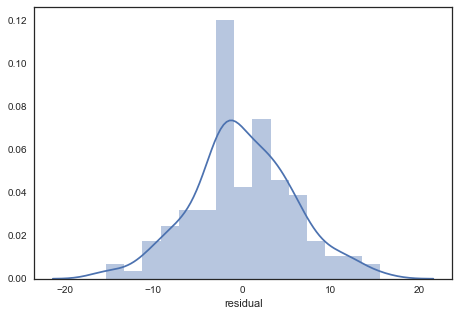

In [21]:
# residuals showing normal distribution. model is correct 

sns.distplot(pred_df['residual'], bins=15)
plt.show()

---

## Part 5 - Pick Promotion and Market

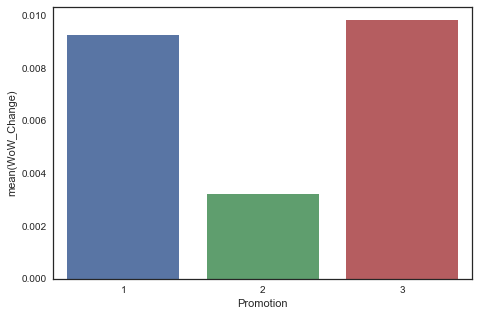

In [22]:
promoGrowth = pd.DataFrame(data.groupby(['Promotion'])['WoW_Change'].mean()).reset_index()
sns.barplot(data=promoGrowth, x='Promotion', y='WoW_Change')
plt.show()

# Promotion #3 saw the best average growth week over week

In [23]:
promoMarket = pd.DataFrame(data.groupby(['MarketID'])['WoW_Change'].\
                             mean()).reset_index().sort_values('WoW_Change', ascending=False).\
                                head(2).reset_index(drop=True)
promoMarket

# MarketID #4 clearly saw the best average Week over Week growth

,MarketID,WoW_Change
0,4,0.034481
1,9,0.018491


---

## Part 6 - Export the Model and Share with Analysts

In [24]:
import pickle
from sklearn.externals import joblib

In [31]:
joblib.dump(model, 'model.pkl')

['model.pkl']

## Part 7 - Recap and Takeaways

In this analysis, we loaded and explored our data. We found that Promotion #2 was not performing well and there were no outliers. 

Next, we began creating features. We calculated week over week growth, which is more important than overall sales in this case. This is because we are examining the impact a marketing campaign had. Overall sales would not be a good indicator of this. We also created features for our model to learn off of in the next section. 

We test two models, a basic linear regression model which did not score well, and the gradient boosted regression model, which did score well. Gradient boosted regression modeling essentially creates a decision tree of regression models and optimizes for the best performer. We then took a look at which features were key drivers of sales. We found that the feature that we created, which concatenates LocationID and Store Age was the most important feature. We can use this model to forecast Week 5 sales.

Lastly, we answered our original question, which was which campaign and which market to run in. For this, we wanted to look at the average overall growth in each category. We found that that promotion #3 was seeing the best growth, and that MarketID #4 was the clearcut winner for the Market with the best average week over week growth. 
